In [8]:
import numpy as np
import cv2
import random
import json
import pickle
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import colorsys
from matplotlib.widgets import Button
import ipywidgets as widgets
from IPython.display import display
import time
%matplotlib notebook

In [28]:
#path of files with results of previously done test of a model. Generally in "evaluator_output". Each one with the name to display
#a dictionary where the keys are the image id and the values are lists of bboxes. Each bbox is a list of 5 values:x,y,w,h and class
#x,y values are the center of the bbox instead of top left
#they all must have the results for every caption of at least the first one
results = {
    "TRAN2LY_UF" : "../Spatial CommonSense Test/results/TRAN2LYunfrozen_max/TRAN2LY.unfrozen_max_69_height.json",
    "STRAN2LY_UF" : "../Spatial CommonSense Test/results/STRAN2LYunfrozen/STRAN2LY.unfrozen_99_height.json"
}

In [29]:
results_data = {}
for arq, data_path in results.items():
    with open(data_path, 'r') as f:
        results_data[arq] = [json.loads(line) for line in f]

In [30]:
with open('../Spatial CommonSense Test/model_index_to_name.json', 'r') as f:
    class_id_to_name = json.load(f)
all_classes = list(class_id_to_name.values())
print(class_id_to_name)

{'4': 'person', '5': 'bicycle', '6': 'car', '7': 'motorcycle', '8': 'airplane', '9': 'bus', '10': 'train', '11': 'truck', '12': 'boat', '13': 'traffic light', '14': 'fire hydrant', '15': 'stop sign', '16': 'parking meter', '17': 'bench', '18': 'bird', '19': 'cat', '20': 'dog', '21': 'horse', '22': 'sheep', '23': 'cow', '24': 'elephant', '25': 'bear', '26': 'zebra', '27': 'giraffe', '28': 'backpack', '29': 'umbrella', '30': 'handbag', '31': 'tie', '32': 'suitcase', '33': 'frisbee', '34': 'skis', '35': 'snowboard', '36': 'sports ball', '37': 'kite', '38': 'baseball bat', '39': 'baseball glove', '40': 'skateboard', '41': 'surfboard', '42': 'tennis racket', '43': 'bottle', '44': 'wine glass', '45': 'cup', '46': 'fork', '47': 'knife', '48': 'spoon', '49': 'bowl', '50': 'banana', '51': 'apple', '52': 'sandwich', '53': 'orange', '54': 'broccoli', '55': 'carrot', '56': 'hot dog', '57': 'pizza', '58': 'donut', '59': 'cake', '60': 'chair', '61': 'couch', '62': 'potted plant', '63': 'bed', '64': 

In [31]:
def draw_bboxes(img, bboxes, classes, xy_is_center=True):
    global all_classes
    img_w, img_h, _ = img.shape
    #generate range of colors. One for each class present in the image
    N = len(all_classes)
    HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    for i in range(len(classes)):
        x,y,w,h = bboxes[i]
        c = classes[i]
        class_index = all_classes.index(c)
        class_color = RGB_tuples[class_index]
        if xy_is_center:
            start = int(img_w*(x-(w/2))), int(img_h*(y-(h/2)))
            end = int(img_w*(x+(w/2))), int(img_h*(y+(h/2)))
        else:
            start = int(img_w*(x)), int(img_h*(y))
            end = int(img_w*(x+w)), int(img_h*(y+h))
        img = cv2.rectangle(img, start, end, class_color, img_w//256)
        text_size = img_h//512
        text_origin = list(start)
        text_origin[1] = text_origin[1]+(text_size*20)
        
        img = cv2.putText(img, c, text_origin, cv2.FONT_HERSHEY_SIMPLEX, text_size, class_color)
    return img

In [32]:
#generate lists of images. For each selected image, generate image for ground truth and every results file given

#keys: name of model (or gt). values: list of images to display. 
images_dict = {}
bbox_dict = {}
#list of captions for each image to display
captions = []
results_example = list(results_data.values())[0]
for result in results_example:
    captions.append(result['text'])
#generate models results list
for model_name, model_results in results_data.items():
    images_dict[model_name] = []
    bbox_dict[model_name] = []
    for result in model_results:
        bboxes = result['bboxes']
        classes = result['classes']
        class_names = [class_id_to_name[str(c)] for c in classes]
        img = np.ones((512,512,3)) #white canvas of 512x512 pixels
        img = draw_bboxes(img,bboxes,class_names)

        images_dict[model_name].append(img)
        bbox_dict[model_name].append((bboxes,class_names))

<IPython.core.display.Javascript object>


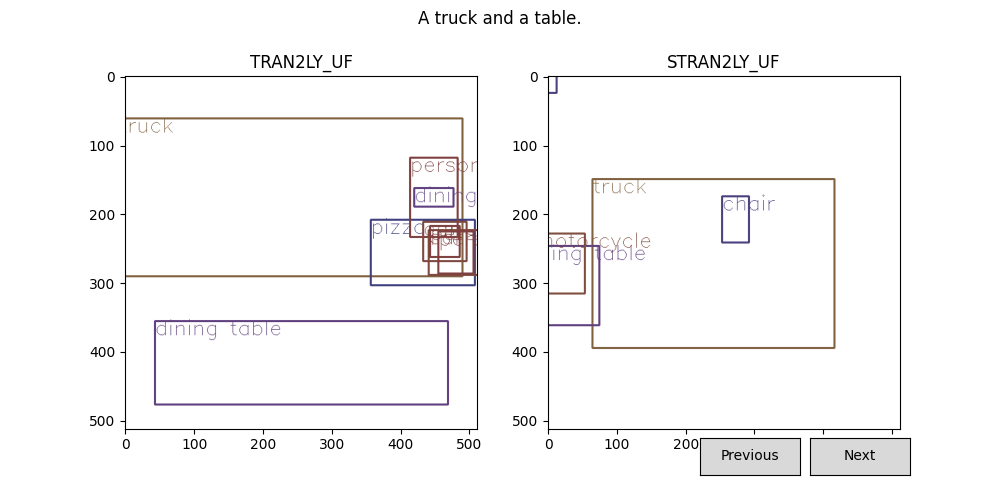

In [33]:
numRows = int(np.ceil(len(images_dict.keys()) / 2))
fig, ax = plt.subplots(numRows,2, figsize=(10,5))
# fig, ax = plt.subplots(1, figsize=(10,5))  # to manually force only gt to appear
ind = 0

model_names = list(images_dict.keys())
model_images = list(images_dict.values())
numResults = len(model_images[0])
#in each ax draws the corresponding image. It also updates title
def draw_images():
    global ind
    global ax
    global images_dict
    global fig
    global captions
    global model_names
    global model_images
    fig.suptitle(captions[ind])
    for i in range(len(model_names)):
        if False:  # manually force only gt to appear
            ax.clear()
            ax.imshow(model_images[0][ind])
            ax.set_title(model_names[0])
        elif len(model_names) < 3:
            col = i%2
            ax[col].clear()
            ax[col].imshow(model_images[i][ind])
            ax[col].set_title(model_names[i])
        else:
            col = i%2
            row = i//2
            ax[row,col].clear()
            ax[row,col].imshow(model_images[i][ind])
            ax[row,col].set_title(model_names[i])
            
def siguiente(event):
    global ind
    global numResults
    ind = min(numResults-1,ind+1)
    draw_images()
def anterior(event):
    global ind
    global numResults
    ind = max(0,ind-1)
    draw_images()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(siguiente)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(anterior)
anterior("ekisde")
plt.show()

In [34]:
#print(captions)
print(model_names)
print(len(model_images))

['TRAN2LY_UF', 'STRAN2LY_UF']
2


In [111]:
print(ind)

0


In [120]:
print(captions[ind])
wut = list(bbox_dict.values())[0][ind]
for i in range(len(wut[0])):
    x,y,w,h = wut[0][i]
    print(wut[1][i], x+(w/2), y+(h/2), w, h, x*512+(w*512)//2, y*512+(h*512//2), w*512, h*512)
print(list(bbox_dict.values())[0][ind])
print(len(list(bbox_dict.values())[0][ind]))

a white dog having its hair blown dry by a man
dog 0.6709921875 0.5193544600938967 0.43479687499999997 0.9395070422535212 343.24 265.3956807511737 222.61599999999999 481.02760563380286
hair drier 0.3463515625 0.6373826291079813 0.283421875 0.4265023474178404 176.776 326.15530516431926 145.112 218.36920187793427
person 0.28065625000000005 0.49753521126760564 0.5581875000000001 0.9573239436619718 142.8 254.6630985915493 285.79200000000003 490.1498591549296
(array([[0.45359375, 0.04960094, 0.43479687, 0.93950704],
       [0.20464062, 0.42413146, 0.28342187, 0.42650235],
       [0.0015625 , 0.01887324, 0.5581875 , 0.95732394]]), ['dog', 'hair drier', 'person'])
2


drawing bbox 0.45359375 0.049600938967136146 0.43479687499999997 0.9395070422535212
start (232, 25) end (454, 506)
drawing bbox 0.204640625 0.42413145539906105 0.283421875 0.4265023474178404
start (104, 217) end (249, 435)
drawing bbox 0.0015625 0.018873239436619716 0.5581875000000001 0.9573239436619718
start (0, 9) end (286, 499)


<IPython.core.display.Javascript object>


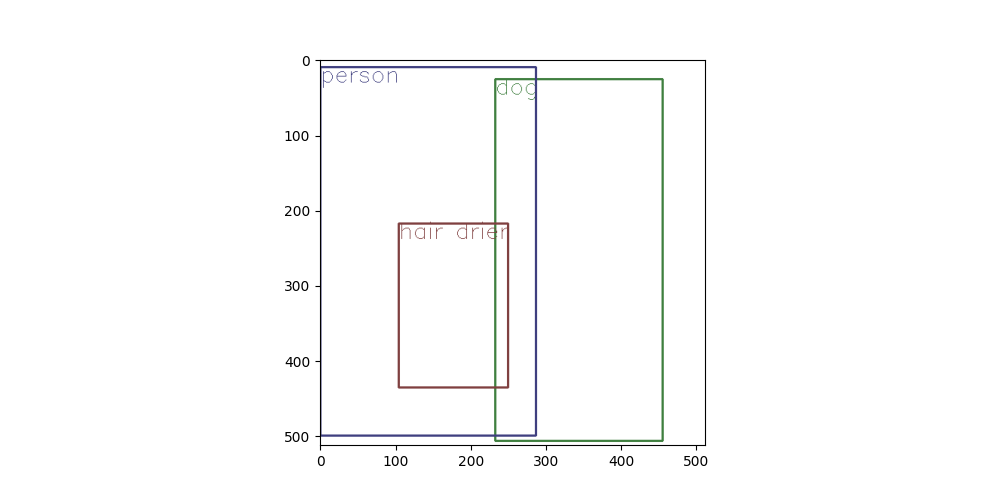

In [118]:
img = np.ones((512,512,3)) #white canvas of 512x512 pixels
img = draw_bboxes(img,wut[0],wut[1], xy_is_center=False)
fig, ax = plt.subplots(1, figsize=(10,5))
ax.imshow(img)

In [69]:
kek = [
    'woman and child standing in the all white kitchen'
]
for img_id in captions_dict:
        for xd in captions_dict[img_id]['graphs']:
            if xd['caption'] in kek:
                print(xd['caption'], img_id)

woman and child standing in the all white kitchen 141017
